# Exploratory Data Analysis

## Variables Description

- **flight_id**: A unique identifier assigned to each flight.
- **date**: The date when the flight took place.
- **callsign**: The encrypted callsign associated with the flight.
- **adep**: The code of the departure airport.
- **name_adep**: The name of the departure airport.
- **country_code_adep**: The country code of the departure airport.
- **ades**: The code of the destination airport.
- **name_ades**: The name of the destination airport.
- **country_code_ades**: The country code of the destination airport.
- **actual_offblock_time**: The time when the aircraft started to move from its parking position.
- **arrival_time**: The time of arrival at the destination airport.
- **aircraft_type**: The type of aircraft used for the flight.
- **wtc**: The wake turbulence category of the aircraft.
- **airline**: The encrypted identifier of the airline operating the flight.
- **flight_duration**: The duration of the flight in minutes.
- **taxiout_time**: The time spent taxiing out from the departure airport.
- **flown_distance**: The distance flown during the flight in kilometers.
- **tow**: The target variable representing the actual TakeOff Weight (TOW) of the aircraft.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [2]:
# Load the datasets
challenge_set_original = pd.read_csv('./data/challenge_set.csv')
submission_set_original = pd.read_csv('./data/submission_set.csv')
trajectories_set = pd.read_csv('./data/trajectory_features.csv')
trajectories_set_v3 = pd.read_csv('./data/trajectory_features_v3.csv')

# Display the first few rows of the datasets to understand their structure
# challenge_set.T

print('number of samples in the challenge set:', challenge_set_original.shape)
print('number of samples in the submission set:', submission_set_original.shape)
print('total number of samples:', challenge_set_original.shape[0] + submission_set_original.shape[0])

print('number of trajectories:', trajectories_set_v3.shape)

challenge_set = trajectories_set_v3[trajectories_set_v3['flight_id'].isin(challenge_set_original['flight_id'])]
submission_set = trajectories_set_v3[trajectories_set_v3['flight_id'].isin(submission_set_original['flight_id'])]

print('number of samples in the challenge set (with trajectories):', challenge_set.shape)
print('number of samples in the submission set (with trajectories):', submission_set.shape)

# challenge_set.T

number of samples in the challenge set: (369013, 18)
number of samples in the submission set: (105959, 18)
total number of samples: 474972
number of trajectories: (464592, 64)
number of samples in the challenge set (with trajectories): (360936, 64)
number of samples in the submission set (with trajectories): (103656, 64)


In [3]:
common_columns = set(trajectories_set.columns).intersection(set(trajectories_set_v3.columns))
print(common_columns)

missing_ids_challenge = challenge_set_original[~challenge_set_original['flight_id'].isin(challenge_set['flight_id'])]
missing_ids_submission = submission_set_original[~submission_set_original['flight_id'].isin(submission_set['flight_id'])]

{'date', 'flight_id', 'average_vertical_rate_ENR', 'country_code_ades', 'name_adep', 'tow', 'specific_energy_ENR', 'average_humidity_ENR', 'average_airspeed_ENR', 'track_variation_ENR', 'flown_distance', 'wind_distance_ENR', 'adep', 'taxiout_time', 'airline', 'flown_distance_ENR', 'ades', 'country_code_adep', 'flight_duration', 'groundspeed_ENR', 'average_temperature_ENR', 'actual_offblock_time', 'name_ades', 'wtc', 'callsign', 'aircraft_type', 'arrival_time', 'specific_energy'}


In [4]:
missing_challenge = trajectories_set[trajectories_set['flight_id'].isin(missing_ids_challenge['flight_id'])]
missing_submission = trajectories_set[trajectories_set['flight_id'].isin(missing_ids_submission['flight_id'])]

print(missing_challenge.shape)
print(missing_submission.shape)

to_drop = set(trajectories_set.columns) - set(trajectories_set_v3.columns)
missing_challenge = missing_challenge.drop(columns=to_drop)
missing_submission = missing_submission.drop(columns=to_drop)

(8077, 46)
(2303, 46)


In [5]:
challenge_set = pd.concat([challenge_set, missing_challenge], axis=0, ignore_index=True)
submission_set = pd.concat([submission_set, missing_submission], axis=0, ignore_index=True)

print('number of samples in the challenge set (with trajectories):', challenge_set.shape)
print('number of samples in the submission set (with trajectories):', submission_set.shape)

number of samples in the challenge set (with trajectories): (369013, 64)
number of samples in the submission set (with trajectories): (105959, 64)


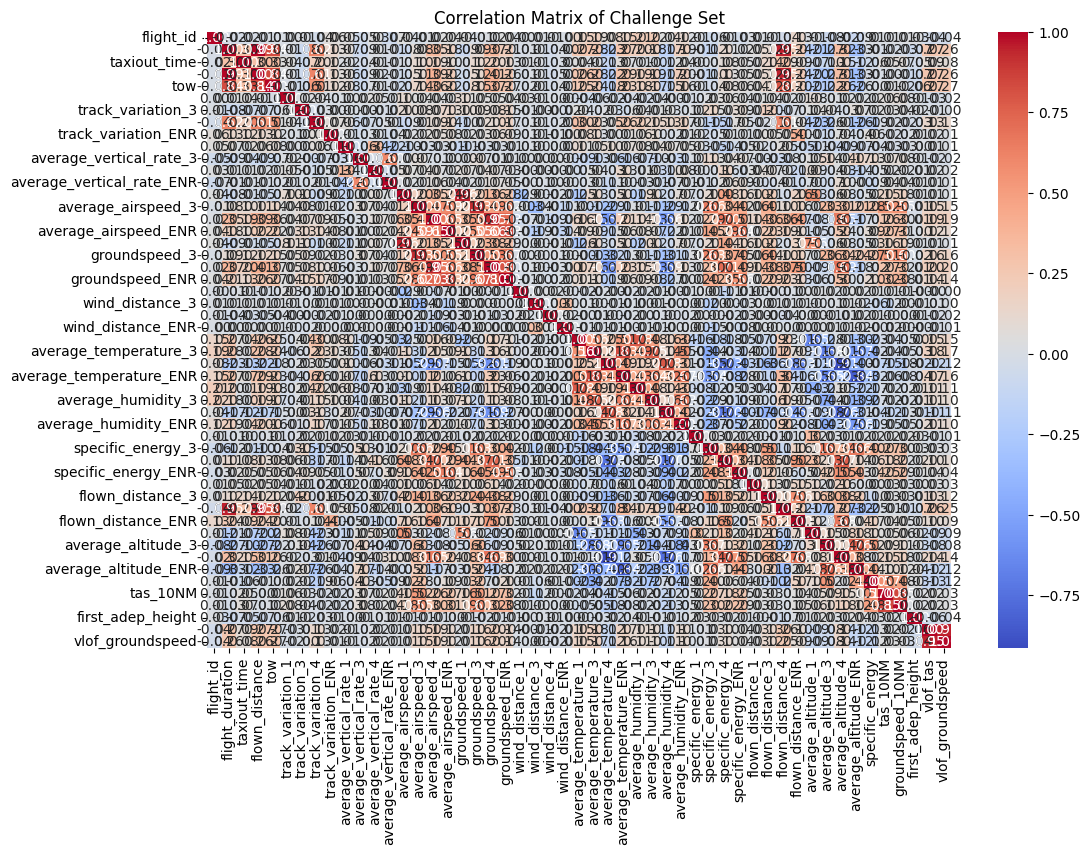

(          flight_id  flight_duration   taxiout_time  flown_distance  \
 count  3.690130e+05    369013.000000  369013.000000   369013.000000   
 mean   2.535220e+08       145.876779      13.489709     1021.728581   
 std    2.688565e+06       139.337587       5.779555     1128.171163   
 min    2.487506e+08         8.000000       0.000000       19.000000   
 25%    2.512296e+08        59.000000      10.000000      338.000000   
 50%    2.536200e+08       100.000000      12.000000      647.000000   
 75%    2.559059e+08       164.000000      16.000000     1113.000000   
 max    2.580745e+08      1013.000000      90.000000     7272.000000   
 
                  tow  track_variation_1  track_variation_3  track_variation_4  \
 count  369013.000000      345273.000000      341449.000000      352489.000000   
 mean    79482.257229          70.157664          65.100437          31.310996   
 std     53250.919631          63.207379          58.956724          32.905881   
 min     14944.000000 

In [6]:
# Summary statistics of the challenge set
challenge_summary = challenge_set.describe()

# Check for missing values
missing_values = challenge_set.isnull().sum()

# Correlation matrix to check relationships between numerical features
correlation_matrix = challenge_set.corr(numeric_only=True)

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

# Display the summary statistics and missing values
challenge_summary, missing_values

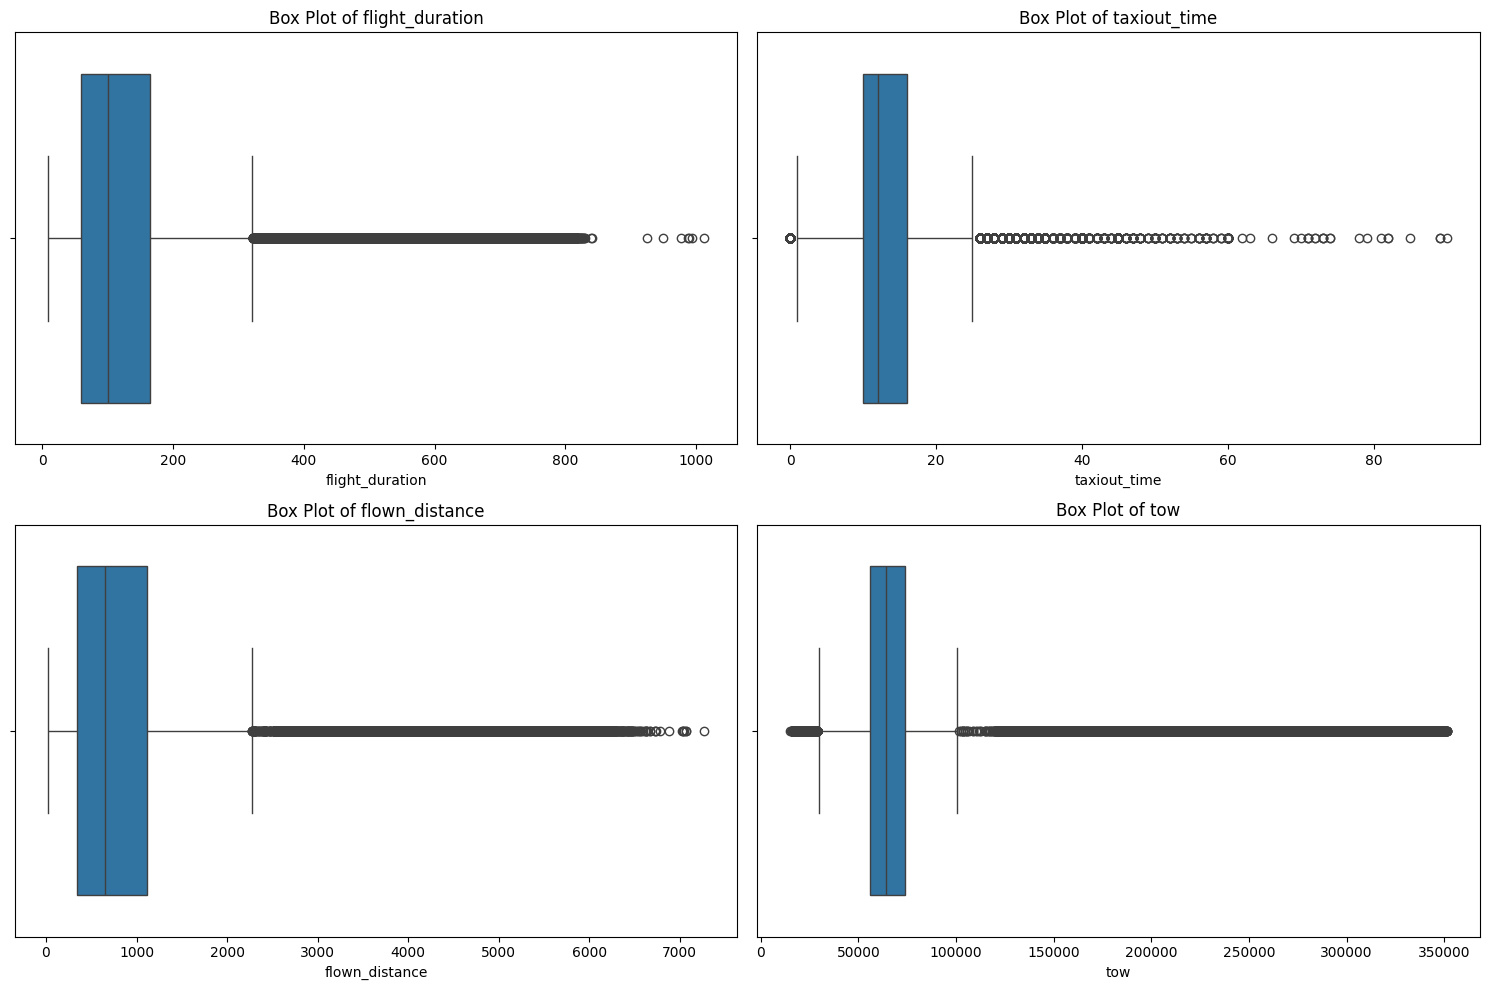

{'flight_duration': 40817,
 'taxiout_time': 10512,
 'flown_distance': 41047,
 'tow': 61165}

In [7]:
# Checking for outliers in numerical features using box plots
numerical_features = ['flight_duration', 'taxiout_time', 'flown_distance', 'tow']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=challenge_set[feature])
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

# Identifying outliers using the Interquartile Range (IQR) method
outliers_info = {}
for feature in numerical_features:
    Q1 = challenge_set[feature].quantile(0.25)
    Q3 = challenge_set[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifying outliers
    outliers = challenge_set[(challenge_set[feature] < lower_bound) | (challenge_set[feature] > upper_bound)]
    outliers_info[feature] = len(outliers)

# Displaying the count of outliers for each feature
outliers_info

# # Removing outliers using the IQR threshold
# def remove_outliers(df, features):
#     for feature in features:
#         Q1 = df[feature].quantile(0.25)
#         Q3 = df[feature].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
#     return df

# # Remove outliers from the challenge set
# cleaned_challenge_set = remove_outliers(challenge_set, numerical_features)

# # Checking the shape of the dataset after outlier removal
# initial_count = len(challenge_set)
# cleaned_count = len(cleaned_challenge_set)

# initial_count, cleaned_count, cleaned_challenge_set.describe()

In [8]:
challenge_set.T

0       \
flight_id                                 248763780   
date                                     2022-01-01   
callsign           3840d84f25d3f5fcc0a1be3076bb4039   
adep                                           EGLL   
name_adep                           London Heathrow   
...                                             ...   
tas_10NM                                 149.896424   
groundspeed_10NM                              242.0   
first_adep_height                              17.0   
vlof_tas                                  85.198766   
vlof_groundspeed                              158.0   

                                             1       \
flight_id                                 248760618   
date                                     2022-01-01   
callsign           f6f610e73002b8892a239a81321f7f1d   
adep                                           LEBL   
name_adep                                 Barcelona   
...                                             ...   
tas_10NM                                 141.328621   
groundspeed_10NM                              259.0   
first_adep_height                              38.0   
vlof_tas                                  81.052932   
vlof_groundspeed                              162.0   

                                             2       \
flight_id                                 248753824   
date                                     2022-01-01   
callsign           139670936660762c230ca92556ba842b   
adep                                           ESSA   
name_adep                         Stockholm Arlanda   
...                                             ...   
tas_10NM                                 156.289942   
groundspeed_10NM                              301.0   
first_adep_height                              13.0   
vlof_tas                                   81.83478   
vlof_groundspeed                              167.0   

                                             3       \
flight_id                                 248753852   
date                                     2022-01-01   
callsign           509dc61bb54fbab0e5406067c95603e2   
adep                                           LSZH   
name_adep                                    Zurich   
...                                             ...   
tas_10NM                                 109.697227   
groundspeed_10NM                              225.0   
first_adep_height                               9.0   
vlof_tas                                  93.299764   
vlof_groundspeed                              179.0   

                                             4       \
flight_id                                 248755934   
date                                     2022-01-01   
callsign           d0610d000dcf26b1d7bba8103ecc393d   
adep                                           EIDW   
name_adep                                    Dublin   
...                                             ...   
tas_10NM                                  128.99446   
groundspeed_10NM                              300.0   
first_adep_height                             383.0   
vlof_tas                                  86.411794   
vlof_groundspeed                              156.0   

                                             5       \
flight_id                                 248762583   
date                                     2022-01-01   
callsign           e6d5d070016d21108f8bd2bd643202ac   
adep                                           ENGM   
name_adep                                      Oslo   
...                                             ...   
tas_10NM                                        NaN   
groundspeed_10NM                                NaN   
first_adep_height                               NaN   
vlof_tas                                        NaN   
vlof_groundspeed                                NaN   

                                             6       \
flight_id               

In [9]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = challenge_set['country_code_adep'].unique()
ades_countries = challenge_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries))

Unique countries in cleaned_challenge_set:
['##', 'AE', 'AL', 'AM', 'AN', 'AO', 'AT', 'AW', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BG', 'BH', 'BJ', 'BR', 'BY', 'CA', 'CD', 'CG', 'CH', 'CI', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EE', 'EG', 'ES', 'ET', 'FI', 'FR', 'GB', 'GE', 'GH', 'GI', 'GR', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JM', 'JO', 'JP', 'KG', 'KR', 'KZ', 'LB', 'LC', 'LR', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MK', 'MN', 'MT', 'MU', 'MX', 'MY', 'NG', 'NL', 'NO', 'NP', 'OM', 'PA', 'PH', 'PK', 'PL', 'PT', 'QA', 'RO', 'RS', 'RU', 'RW', 'SA', 'SD', 'SE', 'SI', 'SK', 'SL', 'SN', 'SO', 'TH', 'TM', 'TN', 'TR', 'TZ', 'UA', 'US', 'UZ', 'VE', 'VN', 'XK', 'ZA']


In [10]:
# Check unique countries in the 'adep' and 'ades' columns
adep_countries = submission_set['country_code_adep'].unique()
ades_countries = submission_set['country_code_ades'].unique()

# Combine both lists to get a unique set of countries
all_countries_sub = set(adep_countries).union(set(ades_countries))

# Display the unique countries
print("Unique countries in cleaned_challenge_set:")
print(sorted(all_countries_sub))

Unique countries in cleaned_challenge_set:
['##', 'AE', 'AL', 'AM', 'AN', 'AT', 'AZ', 'BA', 'BE', 'BG', 'BH', 'BY', 'CA', 'CH', 'CI', 'CR', 'CU', 'CV', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EE', 'EG', 'ER', 'ES', 'FI', 'FR', 'GB', 'GE', 'GR', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JM', 'JO', 'JP', 'KG', 'KZ', 'LB', 'LC', 'LR', 'LT', 'LU', 'LV', 'MA', 'MD', 'ME', 'MK', 'MN', 'MT', 'MX', 'NL', 'NO', 'OM', 'PA', 'PK', 'PL', 'PT', 'QA', 'RO', 'RS', 'RU', 'SA', 'SE', 'SI', 'SK', 'SL', 'SN', 'TH', 'TM', 'TN', 'TR', 'TZ', 'UA', 'US', 'UZ', 'XK', 'ZA']


In [11]:
set(all_countries_sub) - set(all_countries)

{'ER'}

In [12]:
def extract_time_features(df):
    # Converting datetime strings to datetime objects
    df['actual_offblock_time'] = pd.to_datetime(df['actual_offblock_time'])
    df['arrival_time'] = pd.to_datetime(df['arrival_time'])
    
    # Extracting basic time features
    df['offblock_hour'] = df['actual_offblock_time'].dt.hour
    df['offblock_minute'] = df['actual_offblock_time'].dt.minute
    df['offblock_day_of_week'] = df['actual_offblock_time'].dt.dayofweek
    df['offblock_month'] = df['actual_offblock_time'].dt.month
    # df['offblock_day_of_year'] = df['actual_offblock_time'].dt.dayofyear
    df['offblock_week_of_year'] = df['actual_offblock_time'].dt.isocalendar().week
    df['offblock_season'] = df['offblock_month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 
                                                       'Spring' if x in [3, 4, 5] else
                                                       'Summer' if x in [6, 7, 8] else 'Fall')
    
    df['arrival_hour'] = df['arrival_time'].dt.hour
    df['arrival_minute'] = df['arrival_time'].dt.minute

    # Calculating the duration in minutes between offblock and arrival
    df['offblock_to_arrival_duration'] = (df['arrival_time'] - df['actual_offblock_time']).dt.total_seconds() / 60
    
    # Adding boolean flags for weekends and rush hours
    df['is_offblock_weekend'] = df['offblock_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
    df['is_offblock_rush_hour'] = df['offblock_hour'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)
    
    return df

# Creating additional duration-based features
def create_duration_features(df):
    # Replace zero or negative values in flight_duration to avoid division errors
    df['flight_duration'] = df['flight_duration'].replace(0, np.nan)
    df['taxiout_time'] = df['taxiout_time'].replace(0, np.nan)
    
    # Fill NaN values in taxiout_time with the median or a reasonable default
    df['taxiout_time'] = df['taxiout_time'].fillna(df['taxiout_time'].median())
    
    # Calculating the ratio of taxiout time to flight duration with error handling
    df['taxi_ratio'] = df.apply(lambda row: row['taxiout_time'] / row['flight_duration'] 
                                if pd.notnull(row['flight_duration']) else np.nan, axis=1)
    
    # Fill NaN values in taxi_ratio with 0 or a reasonable default (e.g., the median of taxi_ratio)
    df['taxi_ratio'] = df['taxi_ratio'].fillna(df['taxi_ratio'].median())
    
    # Calculating the average flight speed (distance per minute) with error handling
    df['flight_speed'] = df.apply(lambda row: row['flown_distance'] / row['flight_duration'] 
                                  if pd.notnull(row['flown_distance']) and pd.notnull(row['flight_duration']) else np.nan, axis=1)
    
    # Fill NaN values in flight_speed with the median value or a reasonable default
    df['flight_speed'] = df['flight_speed'].fillna(df['flight_speed'].median())
    
    # Normalizing taxi_ratio by the median value to control for large values
    df['normalized_taxi_ratio'] = df['taxi_ratio'] / df['taxi_ratio'].median()
    
    # Categorical features for flight duration buckets
    df['flight_duration_category'] = pd.cut(df['flight_duration'], bins=[0, 60, 180, 300, np.inf], 
                                            labels=['Very Short', 'Short', 'Medium', 'Long'], right=False)
    
    # Speed per distance feature for more detailed analysis
    df['speed_per_distance'] = df.apply(lambda row: row['flight_speed'] / row['flown_distance'] 
                                        if pd.notnull(row['flight_speed']) and pd.notnull(row['flown_distance']) else np.nan, axis=1)
    
    # Fill NaN values in speed_per_distance with the median value or a reasonable default
    df['speed_per_distance'] = df['speed_per_distance'].fillna(df['speed_per_distance'].median())
    
    # Cumulative mean of flight speed to capture trends over time (if data is ordered by time)
    df['cumulative_avg_speed'] = df['flight_speed'].expanding().mean()
    
    # Handling edge cases and setting up conditions for further analysis
    df['taxi_ratio'] = df['taxi_ratio'].replace([np.inf, -np.inf], np.nan)
    df['flight_speed'] = df['flight_speed'].replace([np.inf, -np.inf], np.nan)
    
    return df


# Grouping airports by region based on country codes
def group_airports_by_region(df):
    # Define country groups for regions
    europe_countries = ['GB', 'FR', 'DE', 'ES', 'IT', 'SE', 'CH', 'NL', 'AT', 'IE', 'BE', 'DK', 'FI', 'GR', 'HU', 
                        'IS', 'LT', 'LU', 'LV', 'MT', 'NO', 'PL', 'PT', 'RO', 'SI', 'SK', 'CZ', 'EE', 'BG', 'CY']
    north_america_countries = ['US', 'CA', 'MX']
    south_america_countries = ['BR', 'AR', 'CL', 'CO', 'PE', 'VE', 'UY', 'PY', 'BO', 'EC', 'GY', 'SR']
    middle_east_countries = ['AE', 'SA', 'IL', 'IR', 'IQ', 'JO', 'KW', 'OM', 'QA', 'BH', 'LB', 'SY', 'YE']
    asia_countries = ['JP', 'CN', 'KR', 'IN', 'PK', 'BD', 'VN', 'PH', 'TH', 'MY', 'ID', 'SG', 'MN', 'KZ', 'TM', 'UZ', 'KG']
    africa_countries = ['ZA', 'NG', 'EG', 'DZ', 'MA', 'KE', 'TZ', 'GH', 'ET', 'CI', 'SN', 'SD', 'AO', 'LR', 'RW', 'ER']
    other_countries = set(df['country_code_adep'].unique()).union(set(df['country_code_ades'].unique())) - set(europe_countries + 
                       north_america_countries + south_america_countries + middle_east_countries + asia_countries + africa_countries)

    # Apply region categorization based on country codes
    def categorize_region(code):
        if code in europe_countries:
            return 'Europe'
        elif code in north_america_countries:
            return 'North America'
        elif code in south_america_countries:
            return 'South America'
        elif code in middle_east_countries:
            return 'Middle East'
        elif code in asia_countries:
            return 'Asia'
        elif code in africa_countries:
            return 'Africa'
        elif code in other_countries:
            return 'Other'
        else:
            return 'Unknown'

    # Apply region classification for adep and ades
    df['adep_region'] = df['country_code_adep'].apply(categorize_region)
    df['ades_region'] = df['country_code_ades'].apply(categorize_region)

    return df

# Update functions to remove original columns where applicable
def extract_country_features(df):
    # Basic feature indicating if the flight is within the same country
    df['same_country_flight'] = (df['country_code_adep'] == df['country_code_ades']).astype(int)

    # Feature indicating if the flight is within the same region
    df['same_region_flight'] = (df['adep_region'] == df['ades_region']).astype(int)

    # Flight direction based on regions: North-South, East-West, or Other
    df['flight_direction'] = df.apply(lambda row: 'North-South' if row['adep_region'] in ['North America', 'Europe'] and
                                                      row['ades_region'] in ['South America', 'Africa'] else
                                                      'East-West' if row['adep_region'] in ['Europe', 'Asia'] and 
                                                      row['ades_region'] in ['North America'] else 'Other', axis=1)

    # Create a feature indicating if the flight is intercontinental
    intercontinental_regions = ['Europe', 'North America', 'South America', 'Middle East', 'Asia', 'Africa']
    df['is_intercontinental'] = df.apply(
        lambda row: 1 if row['adep_region'] in intercontinental_regions and 
                         row['ades_region'] in intercontinental_regions and 
                         row['adep_region'] != row['ades_region'] else 0, axis=1)
    return df

# Function to remove original columns after feature extraction
def remove_columns(df, columns_to_remove):
    # Removing original datetime columns since features have been extracted
    df = df.drop(columns_to_remove, axis=1)
    return df

# List of columns to remove after feature extraction
columns_to_remove = ['name_adep', 'name_ades', 'country_code_adep', 'country_code_ades', 'flight_id', 'callsign', 'date', 'actual_offblock_time', 'arrival_time', 'flight_duration']

# Applying functions to the challenge set
cleaned_challenge_set = extract_time_features(challenge_set)
cleaned_challenge_set = create_duration_features(cleaned_challenge_set)
cleaned_challenge_set = group_airports_by_region(cleaned_challenge_set)
cleaned_challenge_set = extract_country_features(cleaned_challenge_set)
cleaned_challenge_set = remove_columns(cleaned_challenge_set, columns_to_remove)

# Applying functions to the submission set
cleaned_submission_set = extract_time_features(submission_set)
cleaned_submission_set = create_duration_features(cleaned_submission_set)
cleaned_submission_set = group_airports_by_region(cleaned_submission_set)
cleaned_submission_set = extract_country_features(cleaned_submission_set)
cleaned_submission_set = remove_columns(cleaned_submission_set, columns_to_remove)

# Display the transposed first few rows of the updated challenge set for review
cleaned_challenge_set.T

0       \
adep                                             EGLL   
ades                                             EICK   
aircraft_type                                    A320   
wtc                                                 M   
airline              a73f82288988b79be490c6322f4c32ed   
...                                               ...   
ades_region                                    Europe   
same_country_flight                                 0   
same_region_flight                                  1   
flight_direction                                Other   
is_intercontinental                                 0   

                                               1       \
adep                                             LEBL   
ades                                             KMIA   
aircraft_type                                    B772   
wtc                                                 H   
airline              5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                               ...   
ades_region                             North America   
same_country_flight                                 0   
same_region_flight                                  0   
flight_direction                            East-West   
is_intercontinental                                 1   

                                               2       \
adep                                             ESSA   
ades                                             KORD   
aircraft_type                                    A333   
wtc                                                 H   
airline              8be5c854fd664bcb97fb543339f74770   
...                                               ...   
ades_region                             North America   
same_country_flight                                 0   
same_region_flight                                  0   
flight_direction                            East-West   
is_intercontinental                                 1   

                                               3       \
adep                                             LSZH   
ades                                             KPHL   
aircraft_type                                    B788   
wtc                                                 H   
airline              5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                               ...   
ades_region                             North America   
same_country_flight                                 0   
same_region_flight                                  0   
flight_direction                            East-West   
is_intercontinental                                 1   

                                               4       \
adep                                             EIDW   
ades                                             EGLL   
aircraft_type                                    A21N   
wtc                                                 M   
airline              a73f82288988b79be490c6322f4c32ed   
...                                               ...   
ades_region                                    Europe   
same_country_flight                                 0   
same_region_flight                                  1   
flight_direction                                Other   
is_intercontinental                                 0   

                                               5       \
adep                                             ENGM   
ades                                             LEAL   
aircraft_type                                    A20N   
wtc                                                 M   
airline              8be5c854fd664bcb97fb543339f74770   
...                                               ...   
ades_region                                    Europe   
same_country_flight                                 0   
same_region_flight                                  1   
flight_direction                                Othe

In [13]:
challenge_set['aircraft_type'].value_counts()

aircraft_type
A320    79761
A20N    37944
B738    37495
A321    29423
E195    24914
A21N    23257
CRJ9    22926
A319    17578
A333    17011
B38M    12330
BCS3    11936
B77W     9162
B772     8322
AT76     6897
B788     5960
B789     5734
BCS1     4649
B737     3627
A332     2241
E190     2105
B739     1793
A359     1725
B763     1190
B39M      542
A343      480
B752        6
A310        2
B773        1
C56X        1
E290        1
Name: count, dtype: int64

In [14]:
# Extracting unique aircraft types from each set
challenge_aircraft_types = set(challenge_set['aircraft_type'].unique())
submission_aircraft_types = set(submission_set['aircraft_type'].unique())

# Aircraft types in challenge_set but not in submission_set
only_in_challenge = challenge_aircraft_types - submission_aircraft_types
print("Aircraft types only in challenge_set:", only_in_challenge)

# Aircraft types in submission_set but not in challenge_set
only_in_submission = submission_aircraft_types - challenge_aircraft_types
print("Aircraft types only in submission_set:", only_in_submission)


Aircraft types only in challenge_set: {'A310', 'C56X'}
Aircraft types only in submission_set: set()


In [15]:
# Load the FAA Aircraft Characteristics Database from the uploaded Excel file
file_path = "./extra_data/FAA-Aircraft-Char-DB-AC-150-5300-13B-App-2023-09-07.xlsx"

# Load the FAA dataset and select relevant columns
faa_data = pd.read_excel(file_path, sheet_name='ACD_Data')

# Select relevant columns for merging
faa_relevant_columns = [
    'FAA_Designator', 'MTOW_lb', 'MALW_lb', 'Manufacturer', 'Model_FAA',
    'Physical_Class_Engine', 'Num_Engines', 'Approach_Speed_knot', 
    'FAA_Weight'
]

# Prepare the FAA data for merging
faa_clean = faa_data[faa_relevant_columns].dropna()

# Convert MTOW and MALW from pounds to kilograms for consistency
faa_clean['MTOW_kg'] = faa_clean['MTOW_lb'] * 0.453592
faa_clean['MALW_kg'] = faa_clean['MALW_lb'] * 0.453592

# Merge the cleaned_challenge_set with FAA data on aircraft_type and FAA_Designator
cleaned_challenge_set = cleaned_challenge_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)

# Merge the cleaned_submission_set with FAA data on aircraft_type and FAA_Designator
cleaned_submission_set = cleaned_submission_set.merge(
    faa_clean, how='left', left_on='aircraft_type', right_on='FAA_Designator'
)
cleaned_challenge_set.T

0       \
adep                                             EGLL   
ades                                             EICK   
aircraft_type                                    A320   
wtc                                                 M   
airline              a73f82288988b79be490c6322f4c32ed   
...                                               ...   
Num_Engines                                         2   
Approach_Speed_knot                             136.0   
FAA_Weight                                      Large   
MTOW_kg                                  78000.133912   
MALW_kg                                   65999.90396   

                                               1       \
adep                                             LEBL   
ades                                             KMIA   
aircraft_type                                    B772   
wtc                                                 H   
airline              5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                               ...   
Num_Engines                                         2   
Approach_Speed_knot                             140.0   
FAA_Weight                                      Heavy   
MTOW_kg                                    297556.352   
MALW_kg                                     213188.24   

                                               2       \
adep                                             ESSA   
ades                                             KORD   
aircraft_type                                    A333   
wtc                                                 H   
airline              8be5c854fd664bcb97fb543339f74770   
...                                               ...   
Num_Engines                                         2   
Approach_Speed_knot                             137.0   
FAA_Weight                                      Heavy   
MTOW_kg                                 241999.950248   
MALW_kg                                 186999.652288   

                                               3       \
adep                                             LSZH   
ades                                             KPHL   
aircraft_type                                    B788   
wtc                                                 H   
airline              5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                               ...   
Num_Engines                                         2   
Approach_Speed_knot                             144.0   
FAA_Weight                                      Heavy   
MTOW_kg                                     227929.98   
MALW_kg                                     172364.96   

                                               4       \
adep                                             EIDW   
ades                                             EGLL   
aircraft_type                                    A21N   
wtc                                                 M   
airline              a73f82288988b79be490c6322f4c32ed   
...                                               ...   
Num_Engines                                         2   
Approach_Speed_knot                             136.0   
FAA_Weight                                      Large   
MTOW_kg                                  94999.854888   
MALW_kg                                  79199.884752   

                                               5       \
adep                                             ENGM   
ades                                             LEAL   
aircraft_type                                    A20N   
wtc                                                 M   
airline              8be5c854fd664bcb97fb543339f74770   
...                                               ...   
Num_Engines                                         2   
Approach_Speed_knot                             137.0   
FAA_Weight                                      Large   
MTOW_kg                                   78999.8506

In [16]:
cleaned_challenge_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)
cleaned_submission_set.drop(["FAA_Designator", "MTOW_lb", "MALW_lb"], axis=1, inplace=True)

In [17]:
# Check for unique aircraft types in the cleaned challenge set
unique_aircraft_types = cleaned_challenge_set['aircraft_type'].unique()

# Check which aircraft types from the challenge set are not present in the FAA data
missing_aircraft_types = [atype for atype in unique_aircraft_types if atype not in faa_data['FAA_Designator'].unique()]

missing_aircraft_types


[]

In [18]:
# Load the GlobalAirportDatabase.txt into a DataFrame
columns_global = ['ICAO', 'IATA', 'Airport Name', 'City/Town', 'Country', 
                  'Latitude Degrees', 'Latitude Minutes', 'Latitude Seconds', 'Latitude Direction',
                  'Longitude Degrees', 'Longitude Minutes', 'Longitude Seconds', 'Longitude Direction',
                  'Altitude', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees']
global_airports = pd.read_csv('./extra_data/GlobalAirportDatabase.txt', sep=':', header=None, names=columns_global)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
global_airports = global_airports[['ICAO', 'Latitude Decimal Degrees', 'Longitude Decimal Degrees', 'Altitude']]

# Load the airports.dat file (assuming previous naming and structure)
columns_openflights = ['Airport ID', 'Name', 'City', 'Country', 'IATA', 'ICAO', 
                       'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Tz database time zone', 
                       'Type', 'Source']
openflights_airports = pd.read_csv('./extra_data/airports.dat', header=None, names=columns_openflights)

# Select relevant columns including Altitude (ICAO, Latitude Decimal Degrees, Longitude Decimal Degrees, Altitude)
openflights_airports = openflights_airports[['ICAO', 'Latitude', 'Longitude', 'Altitude']]
openflights_airports.rename(columns={'Latitude': 'Latitude Decimal Degrees', 
                                     'Longitude': 'Longitude Decimal Degrees'}, inplace=True)

# Concatenate both datasets, removing duplicates based on ICAO codes
airports = pd.concat([global_airports, openflights_airports]).drop_duplicates(subset=['ICAO'])

# Display the combined dataset to verify the merge
airports.head()

ICAO  Latitude Decimal Degrees  Longitude Decimal Degrees  Altitude
0  AYGA                    -6.082                    145.392      1610
1  AYLA                     0.000                      0.000         0
2  AYMD                    -5.207                    145.789         7
3  AYMH                    -5.826                    144.296      1643
4  AYNZ                    -6.570                    146.726        73

In [19]:
# Backup
backup_challenge_set = cleaned_challenge_set.copy()

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports

# Merge for adep (departure airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_challenge_set = pd.merge(
    cleaned_challenge_set, airports, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_challenge_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

# Display the transposed DataFrame to confirm the correct columns are retained
cleaned_challenge_set.T

0       \
adep                                        EGLL   
ades                                        EICK   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79be490c6322f4c32ed   
...                                          ...   
Altitude_adep                               25.0   
ICAO_ades                                   EICK   
Latitude_ades                             51.843   
Longitude_ades                            -8.492   
Altitude_ades                              154.0   

                                          1       \
adep                                        LEBL   
ades                                        KMIA   
aircraft_type                               B772   
wtc                                            H   
airline         5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                          ...   
Altitude_adep                                4.0   
ICAO_ades                                   KMIA   
Latitude_ades                             25.793   
Longitude_ades                           -80.291   
Altitude_ades                                3.0   

                                          2       \
adep                                        ESSA   
ades                                        KORD   
aircraft_type                               A333   
wtc                                            H   
airline         8be5c854fd664bcb97fb543339f74770   
...                                          ...   
Altitude_adep                               38.0   
ICAO_ades                                   KORD   
Latitude_ades                             41.979   
Longitude_ades                           -87.904   
Altitude_ades                              204.0   

                                          3       \
adep                                        LSZH   
ades                                        KPHL   
aircraft_type                               B788   
wtc                                            H   
airline         5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                          ...   
Altitude_adep                              432.0   
ICAO_ades                                   KPHL   
Latitude_ades                             39.872   
Longitude_ades                           -75.241   
Altitude_ades                               12.0   

                                          4       \
adep                                        EIDW   
ades                                        EGLL   
aircraft_type                               A21N   
wtc                                            M   
airline         a73f82288988b79be490c6322f4c32ed   
...                                          ...   
Altitude_adep                               74.0   
ICAO_ades                                   EGLL   
Latitude_ades                             51.477   
Longitude_ades                            -0.461   
Altitude_ades                               25.0   

                                          5       \
adep                                        ENGM   
ades                                        LEAL   
aircraft_type                               A20N   
wtc                                            M   
airline         8be5c854fd664bcb97fb543339f74770   
...                                          ...   
Altitude_adep                              208.0   
ICAO_ades                                   LEAL   
Latitude_ades                             38.282   
Longitude_ades                            -0.558   
Altitude_ades                               44.0   

                                          6       \
adep                                        EGAC   
ades                                        EGLL   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79b

In [20]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = cleaned_challenge_set.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = cleaned_challenge_set[cleaned_challenge_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = cleaned_challenge_set[cleaned_challenge_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(9, {'HSSK', 'LFTM', 'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'})

In [21]:
challenge_set['taxiout_time'].iloc[827]

5.0

In [22]:
cleaned_challenge_set['taxiout_time'].iloc[827]

5.0

In [23]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = cleaned_challenge_set[cleaned_challenge_set.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values.T

5       \
adep                                        ENGM   
ades                                        LEAL   
aircraft_type                               A20N   
wtc                                            M   
airline         8be5c854fd664bcb97fb543339f74770   
...                                          ...   
Altitude_adep                              208.0   
ICAO_ades                                   LEAL   
Latitude_ades                             38.282   
Longitude_ades                            -0.558   
Altitude_ades                               44.0   

                                          9       \
adep                                        LTFM   
ades                                        LTAC   
aircraft_type                               A321   
wtc                                            M   
airline         6351ec1b849adacc0cbb3b1313d8d39b   
...                                          ...   
Altitude_adep                              325.0   
ICAO_ades                                   LTAC   
Latitude_ades                             40.128   
Longitude_ades                            32.995   
Altitude_ades                              953.0   

                                          10      \
adep                                        LOWW   
ades                                        EDDM   
aircraft_type                               A320   
wtc                                            M   
airline         5d407cb11cc29578cc3e292e743f5393   
...                                          ...   
Altitude_adep                              183.0   
ICAO_ades                                   EDDM   
Latitude_ades                             48.354   
Longitude_ades                            11.786   
Altitude_ades                              454.0   

                                          11      \
adep                                        LSZH   
ades                                        ESGG   
aircraft_type                               A320   
wtc                                            M   
airline         2d5def0a5a844b343ba1b7cc9cb28fa9   
...                                          ...   
Altitude_adep                              432.0   
ICAO_ades                                   ESGG   
Latitude_ades                             57.663   
Longitude_ades                             12.28   
Altitude_ades                              155.0   

                                          14      \
adep                                        LTAT   
ades                                        LTAC   
aircraft_type                               B738   
wtc                                            M   
airline         6351ec1b849adacc0cbb3b1313d8d39b   
...                                          ...   
Altitude_adep                              862.0   
ICAO_ades                                   LTAC   
Latitude_ades                             40.128   
Longitude_ades                            32.995   
Altitude_ades                              953.0   

                                          23      \
adep                                        EGPF   
ades                                        EIDW   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79be490c6322f4c32ed   
...                                          ...   
Altitude_adep                                8.0   
ICAO_ades                                   EIDW   
Latitude_ades                             53.421   
Longitude_ades                             -6.27   
Altitude_ades                               74.0   

                                          25      \
adep                                        KCLT   
ades                                        EGLL   
aircraft_type                               B772   
wtc                                            H   
airline         5543e4dc327359ff

In [24]:
# Applying the same transformations for submission_set as described for challenge_set

# Backup
backup_submission_set = cleaned_submission_set.copy()

# Filter updated_airports to include only ICAO codes present in cleaned_submission_set (adep and ades)
relevant_icaos_submission = cleaned_submission_set['adep'].unique().tolist() + cleaned_submission_set['ades'].unique().tolist()
filtered_airports_submission = airports[airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
cleaned_submission_set = pd.merge(
    cleaned_submission_set, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
cleaned_submission_set.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

cleaned_submission_set.T

0       \
adep                                        LTFJ   
ades                                        LFLL   
aircraft_type                               B738   
wtc                                            M   
airline         6351ec1b849adacc0cbb3b1313d8d39b   
...                                          ...   
Altitude_adep                              312.0   
ICAO_ades                                   LFLL   
Latitude_ades                             45.726   
Longitude_ades                             5.091   
Altitude_ades                              251.0   

                                          1       \
adep                                        EBBR   
ades                                        KJFK   
aircraft_type                               A333   
wtc                                            H   
airline         bdeeef3a675587d530de70a25d7118d2   
...                                          ...   
Altitude_adep                               57.0   
ICAO_ades                                   KJFK   
Latitude_ades                              40.64   
Longitude_ades                           -73.779   
Altitude_ades                                4.0   

                                          2       \
adep                                        KMIA   
ades                                        EGLL   
aircraft_type                               B77W   
wtc                                            H   
airline         5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                          ...   
Altitude_adep                                3.0   
ICAO_ades                                   EGLL   
Latitude_ades                             51.477   
Longitude_ades                            -0.461   
Altitude_ades                               25.0   

                                          3       \
adep                                        EGCN   
ades                                        LEAL   
aircraft_type                               B38M   
wtc                                            M   
airline         3922524069809ac4326134429751e26f   
...                                          ...   
Altitude_adep                               55.0   
ICAO_ades                                   LEAL   
Latitude_ades                             38.282   
Longitude_ades                            -0.558   
Altitude_ades                               44.0   

                                          4       \
adep                                        EIDW   
ades                                        LFLL   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79be490c6322f4c32ed   
...                                          ...   
Altitude_adep                               74.0   
ICAO_ades                                   LFLL   
Latitude_ades                             45.726   
Longitude_ades                             5.091   
Altitude_ades                              251.0   

                                          5       \
adep                                        LTFJ   
ades                                        LTAC   
aircraft_type                               B738   
wtc                                            M   
airline         6351ec1b849adacc0cbb3b1313d8d39b   
...                                          ...   
Altitude_adep                              312.0   
ICAO_ades                                   LTAC   
Latitude_ades                             40.128   
Longitude_ades                            32.995   
Altitude_ades                              953.0   

                                          6       \
adep                                        EGLL   
ades                                        EIDW   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79b

In [25]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = cleaned_submission_set.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = cleaned_submission_set[cleaned_submission_set['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = cleaned_submission_set[cleaned_submission_set['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(6, {'LTFG', 'LTFO', 'UCFM', 'UTFF', 'VOGO', 'ZMCK'})

In [26]:
# Coordinates for the given ICAO codes

new_airports = {
    'ICAO': ['CYHZ', 'EDDE', 'KDAB', 'KRFD', 'LIPO', 'LTAP', 'HSSK', 'LFTM', 'LTFG', 
             'LTFO', 'UCFM', 'UTFF', 'VGHS', 'VOGO', 'ZMCK'],
    'Latitude Decimal Degrees': [44.8800, 50.9798, 29.1799, 42.1954, 45.4289, 40.0714, 
                                 15.5895, 40.9769, 36.2994, 38.7262, 43.0613, 40.3581, 
                                 23.8433, 15.3808, 48.1357],
    'Longitude Decimal Degrees': [-63.5086, 10.9581, -81.0581, -89.0972, 10.3306, 32.5644, 
                                  32.5532, 28.8146, 32.3006, 30.6015, 74.4776, 71.7450, 
                                  90.3978, 73.8314, 114.6460],
    'Altitude': [145, 316, 11, 224, 109, 535, 386, 35, 28, 1003, 627, 577, 8, 56, 751]
}

# Convert new airports data to DataFrame
new_airports_df = pd.DataFrame(new_airports)

# Append the new rows to the existing DataFrame
updated_airports = pd.concat([airports, new_airports_df], ignore_index=True)

updated_airports = updated_airports.drop_duplicates(subset=['ICAO'])

In [27]:
# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_challenge = backup_challenge_set['adep'].unique().tolist() + backup_challenge_set['ades'].unique().tolist()
filtered_airports_challenge = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_challenge)]

# Merge airports data to cleaned_challenge_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
challenge_set_updated = pd.merge(
    backup_challenge_set, filtered_airports_challenge, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
challenge_set_updated = pd.merge(
    challenge_set_updated, filtered_airports_challenge, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
challenge_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True)


# Display the transposed DataFrame to confirm the correct columns are retained
challenge_set_updated.T

0       \
adep                                        EGLL   
ades                                        EICK   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79be490c6322f4c32ed   
...                                          ...   
Altitude_adep                                 25   
ICAO_ades                                   EICK   
Latitude_ades                             51.843   
Longitude_ades                            -8.492   
Altitude_ades                                154   

                                          1       \
adep                                        LEBL   
ades                                        KMIA   
aircraft_type                               B772   
wtc                                            H   
airline         5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                          ...   
Altitude_adep                                  4   
ICAO_ades                                   KMIA   
Latitude_ades                             25.793   
Longitude_ades                           -80.291   
Altitude_ades                                  3   

                                          2       \
adep                                        ESSA   
ades                                        KORD   
aircraft_type                               A333   
wtc                                            H   
airline         8be5c854fd664bcb97fb543339f74770   
...                                          ...   
Altitude_adep                                 38   
ICAO_ades                                   KORD   
Latitude_ades                             41.979   
Longitude_ades                           -87.904   
Altitude_ades                                204   

                                          3       \
adep                                        LSZH   
ades                                        KPHL   
aircraft_type                               B788   
wtc                                            H   
airline         5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                          ...   
Altitude_adep                                432   
ICAO_ades                                   KPHL   
Latitude_ades                             39.872   
Longitude_ades                           -75.241   
Altitude_ades                                 12   

                                          4       \
adep                                        EIDW   
ades                                        EGLL   
aircraft_type                               A21N   
wtc                                            M   
airline         a73f82288988b79be490c6322f4c32ed   
...                                          ...   
Altitude_adep                                 74   
ICAO_ades                                   EGLL   
Latitude_ades                             51.477   
Longitude_ades                            -0.461   
Altitude_ades                                 25   

                                          5       \
adep                                        ENGM   
ades                                        LEAL   
aircraft_type                               A20N   
wtc                                            M   
airline         8be5c854fd664bcb97fb543339f74770   
...                                          ...   
Altitude_adep                                208   
ICAO_ades                                   LEAL   
Latitude_ades                             38.282   
Longitude_ades                            -0.558   
Altitude_ades                                 44   

                                          6       \
adep                                        EGAC   
ades                                        EGLL   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79b

In [28]:
# Count missing values for each column in the cleaned_challenge_set DataFrame
missing_values = challenge_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing = missing_values[missing_values > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
# Assuming 'adep' and 'ades' are the columns where ICAO codes are merged
missing_icaos_adep = challenge_set_updated[challenge_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades = challenge_set_updated[challenge_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos = set(missing_icaos_adep).union(set(missing_icaos_ades))

# Count the number of unique ICAO codes missing
unique_missing_count = len(unique_missing_icaos)

unique_missing_count, unique_missing_icaos

(0, set())

In [29]:
# Display rows in the DataFrame that have missing values in any column
rows_with_missing_values = challenge_set_updated[challenge_set_updated.isnull().any(axis=1)]

# Display the rows with missing values
rows_with_missing_values

adep  ades aircraft_type wtc                           airline  \
5       ENGM  LEAL          A20N   M  8be5c854fd664bcb97fb543339f74770   
9       LTFM  LTAC          A321   M  6351ec1b849adacc0cbb3b1313d8d39b   
10      LOWW  EDDM          A320   M  5d407cb11cc29578cc3e292e743f5393   
11      LSZH  ESGG          A320   M  2d5def0a5a844b343ba1b7cc9cb28fa9   
14      LTAT  LTAC          B738   M  6351ec1b849adacc0cbb3b1313d8d39b   
...      ...   ...           ...  ..                               ...   
369008  KMIA  LFPG          B788   H  5543e4dc327359ffaf5b9c0e6faaf0e1   
369009  KLAX  EGLL          B77W   H  5543e4dc327359ffaf5b9c0e6faaf0e1   
369010  KMIA  LLBG          B788   H  5543e4dc327359ffaf5b9c0e6faaf0e1   
369011  LFPG  KMIA          B788   H  5543e4dc327359ffaf5b9c0e6faaf0e1   
369012  LEMD  KJFK          B772   H  5543e4dc327359ffaf5b9c0e6faaf0e1   

        taxiout_time  flown_distance       tow  track_variation_1  \
5               27.0            1434   57721.0         129.905650   
9               25.0             257   73571.0         135.711167   
10              13.0             200   56791.0          78.662068   
11               9.0             689   60826.0         163.442929   
14               5.0             273   52862.0         138.515888   
...              ...             ...       ...                ...   
369008          10.0            4076  152632.0                NaN   
369009          10.0            4911  230327.0                NaN   
369010          10.0            5835  153632.0                NaN   
369011          21.0            4046  163438.0                NaN   
369012          16.0            3213  195373.0                NaN   

        track_variation_3  ...        MTOW_kg        MALW_kg  ICAO  \
5                1.961756  ...   78999.850680   67399.688872  ENGM   
9                     NaN  ...   91000.080632   77800.099840  LTFM   
10              63.320732  ...   78000.133912   65999.903960  LOWW   
11             114.634922  ...   78000.133912   65999.903960  LSZH   
14                    NaN  ...   79015.726400   66349.169800  LTAT   
...                   ...  ...            ...            ...   ...   
369008                NaN  ...  227929.980000  172364.960000  KMIA   
369009                NaN  ...  351533.800000  251289.968000  KLAX   
369010                NaN  ...  227929.980000  172364.960000  KMIA   
369011                NaN  ...  227929.980000  172364.960000  LFPG   
369012                NaN  ...  297556.352000  213188.240000  LEMD   

        Latitude_adep  Longitude_adep  Altitude_adep  ICAO_ades  \
5           60.194000       11.100000            208       LEAL   
9           41.275278       28.751944            325       LTAC   
10          48.110000       16.570000            183       EDDM   
11          47.465000        8.549000            432       ESGG   
14          38.436000       38.092000            862       LTAC   
...               ...             ...            ...        ...   
369008      25.793000      -80.291000              3       LFPG   
369009      33.942000     -118.408000             39       EGLL   
369010      25.793000      -80.291000              3       LLBG   
369011      49.013000        2.550000            120       KMIA   
369012      40.472000       -3.561000            610       KJFK   

        Latitude_ades  Longitude_ades  Altitude_ades  
5              38.282          -0.558             44  
9              40.128          32.995            953  
10             48.354          11.786            454  
11             57.663          12.280            155  
14             40.128          32.995            953  
...               ...             ...            ...  
369008         49.013           2.550            120  
369009         51.477          -0.461             25  
369010         32.009          34.877             42  
369011         25.793         -80.291              3  
369012         40.640         -73.779  

In [30]:
# Applying the same transformations for submission_set as described for challenge_set

# Filter updated_airports to include only ICAO codes present in df (adep and ades)
relevant_icaos_submission = backup_submission_set['adep'].unique().tolist() + backup_submission_set['ades'].unique().tolist()
filtered_airports_submission = updated_airports[updated_airports['ICAO'].isin(relevant_icaos_submission)]

# Merge airports data to submission_set for both departure (adep) and arrival (ades) airports
# Merge for adep (departure airport)
submission_set_updated = pd.merge(
    backup_submission_set, filtered_airports_submission, 
    how='left', left_on='adep', right_on='ICAO', 
    suffixes=('_adep', '')
)

# Rename latitude, longitude, and altitude columns for adep correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_adep', 
        'Longitude Decimal Degrees': 'Longitude_adep',
        'Altitude': 'Altitude_adep'
    }, 
    inplace=True
)

# Merge for ades (arrival airport)
submission_set_updated = pd.merge(
    submission_set_updated, filtered_airports_submission, 
    how='left', left_on='ades', right_on='ICAO', 
    suffixes=('', '_ades')
)

# Rename latitude, longitude, and altitude columns for ades correctly
submission_set_updated.rename(
    columns={
        'Latitude Decimal Degrees': 'Latitude_ades', 
        'Longitude Decimal Degrees': 'Longitude_ades',
        'Altitude': 'Altitude_ades'
    }, 
    inplace=True
)

submission_set_updated.T

0       \
adep                                        LTFJ   
ades                                        LFLL   
aircraft_type                               B738   
wtc                                            M   
airline         6351ec1b849adacc0cbb3b1313d8d39b   
...                                          ...   
Altitude_adep                                312   
ICAO_ades                                   LFLL   
Latitude_ades                             45.726   
Longitude_ades                             5.091   
Altitude_ades                                251   

                                          1       \
adep                                        EBBR   
ades                                        KJFK   
aircraft_type                               A333   
wtc                                            H   
airline         bdeeef3a675587d530de70a25d7118d2   
...                                          ...   
Altitude_adep                                 57   
ICAO_ades                                   KJFK   
Latitude_ades                              40.64   
Longitude_ades                           -73.779   
Altitude_ades                                  4   

                                          2       \
adep                                        KMIA   
ades                                        EGLL   
aircraft_type                               B77W   
wtc                                            H   
airline         5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                          ...   
Altitude_adep                                  3   
ICAO_ades                                   EGLL   
Latitude_ades                             51.477   
Longitude_ades                            -0.461   
Altitude_ades                                 25   

                                          3       \
adep                                        EGCN   
ades                                        LEAL   
aircraft_type                               B38M   
wtc                                            M   
airline         3922524069809ac4326134429751e26f   
...                                          ...   
Altitude_adep                                 55   
ICAO_ades                                   LEAL   
Latitude_ades                             38.282   
Longitude_ades                            -0.558   
Altitude_ades                                 44   

                                          4       \
adep                                        EIDW   
ades                                        LFLL   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79be490c6322f4c32ed   
...                                          ...   
Altitude_adep                                 74   
ICAO_ades                                   LFLL   
Latitude_ades                             45.726   
Longitude_ades                             5.091   
Altitude_ades                                251   

                                          5       \
adep                                        LTFJ   
ades                                        LTAC   
aircraft_type                               B738   
wtc                                            M   
airline         6351ec1b849adacc0cbb3b1313d8d39b   
...                                          ...   
Altitude_adep                                312   
ICAO_ades                                   LTAC   
Latitude_ades                             40.128   
Longitude_ades                            32.995   
Altitude_ades                                953   

                                          6       \
adep                                        EGLL   
ades                                        EIDW   
aircraft_type                               A320   
wtc                                            M   
airline         a73f82288988b79b

In [31]:
# Count missing values for each column in the submission_set_updated DataFrame
missing_values_submission = submission_set_updated.isnull().sum()

# Identify columns with missing values
columns_with_missing_submission = missing_values_submission[missing_values_submission > 0]

# Specifically count the unique missing ICAO codes by examining columns related to ICAO information
missing_icaos_adep_submission = submission_set_updated[submission_set_updated['Latitude_adep'].isnull()]['adep'].unique()
missing_icaos_ades_submission = submission_set_updated[submission_set_updated['Latitude_ades'].isnull()]['ades'].unique()

# Combine both lists to find unique ICAO codes missing in both 'adep' and 'ades'
unique_missing_icaos_submission = set(missing_icaos_adep_submission).union(set(missing_icaos_ades_submission))

# Count the number of unique ICAO codes missing
unique_missing_count_submission = len(unique_missing_icaos_submission)

unique_missing_count_submission, unique_missing_icaos_submission

(0, set())

In [32]:
# Function to calculate actual distance between airports using Haversine formula
def calculate_actual_distance(df):
    # Convert degrees to radians
    lat1 = np.radians(df['Latitude_adep'])
    lon1 = np.radians(df['Longitude_adep'])
    lat2 = np.radians(df['Latitude_ades'])
    lon2 = np.radians(df['Longitude_ades'])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    radius_earth_km = 6371  # Earth radius in kilometers
    df['actual_distance'] = radius_earth_km * c
    
    # Additional features
    df['altitude_difference'] = df['Altitude_ades'] - df['Altitude_adep']  # Vertical distance
    df['bearing'] = np.degrees(np.arctan2(np.sin(dlon) * np.cos(lat2), 
                                           np.cos(lat1) * np.sin(lat2) - 
                                           np.sin(lat1) * np.cos(lat2) * np.cos(dlon)))  # Bearing
    
    df['bearing'] = (df['bearing'] + 360) % 360  # Normalize bearing to 0-360 degrees
    df['elevation_gradient'] = df['altitude_difference'] / df['actual_distance']  # Altitude change per km
    
    return df

# Apply the actual distance calculation and additional features to the challenge set
challenge_set_updated = calculate_actual_distance(challenge_set_updated)
challenge_set_updated = challenge_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

# Apply the actual distance calculation and additional features to the submission set
submission_set_updated = calculate_actual_distance(submission_set_updated)
submission_set_updated = submission_set_updated.drop(['ICAO', 'ICAO_ades'], axis=1)

In [33]:
challenge_set_updated.T

0       \
adep                                             EGLL   
ades                                             EICK   
aircraft_type                                    A320   
wtc                                                 M   
airline              a73f82288988b79be490c6322f4c32ed   
...                                               ...   
Altitude_ades                                     154   
actual_distance                            555.164898   
altitude_difference                               129   
bearing                                    277.346455   
elevation_gradient                           0.232363   

                                               1       \
adep                                             LEBL   
ades                                             KMIA   
aircraft_type                                    B772   
wtc                                                 H   
airline              5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                               ...   
Altitude_ades                                       3   
actual_distance                           7544.863035   
altitude_difference                                -1   
bearing                                    285.530704   
elevation_gradient                          -0.000133   

                                               2       \
adep                                             ESSA   
ades                                             KORD   
aircraft_type                                    A333   
wtc                                                 H   
airline              8be5c854fd664bcb97fb543339f74770   
...                                               ...   
Altitude_ades                                     204   
actual_distance                           6855.624802   
altitude_difference                               166   
bearing                                    305.643136   
elevation_gradient                           0.024214   

                                               3       \
adep                                             LSZH   
ades                                             KPHL   
aircraft_type                                    B788   
wtc                                                 H   
airline              5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                               ...   
Altitude_ades                                      12   
actual_distance                           6459.885397   
altitude_difference                              -420   
bearing                                    296.005451   
elevation_gradient                          -0.065017   

                                               4       \
adep                                             EIDW   
ades                                             EGLL   
aircraft_type                                    A21N   
wtc                                                 M   
airline              a73f82288988b79be490c6322f4c32ed   
...                                               ...   
Altitude_ades                                      25   
actual_distance                            448.923048   
altitude_difference                               -49   
bearing                                    116.445141   
elevation_gradient                           -0.10915   

                                               5       \
adep                                             ENGM   
ades                                             LEAL   
aircraft_type                                    A20N   
wtc                                                 M   
airline              8be5c854fd664bcb97fb543339f74770   
...                                               ...   
Altitude_ades                                      44   
actual_distance                           2570.426742   
altitude_difference                              -164   
bearing                                    203.82976

In [34]:
# List of categorical columns to analyze
categorical_columns = ['aircraft_type', 
                       'wtc', 
                       'airline',
                       'offblock_hour',
                       'offblock_minute', 
                       'offblock_day_of_week',
                       'offblock_month',
                       'offblock_week_of_year', 
                       'offblock_season', 
                       'arrival_hour',
                       'arrival_minute',
                       'is_offblock_weekend',
                       'is_offblock_rush_hour',
                       'flight_duration_category',                       
                       'adep_region', 
                       'ades_region', 
                       'same_country_flight',
                       'same_region_flight',                        
                       'flight_direction',
                       'is_intercontinental',
                       'Manufacturer',
                       'Model_FAA',
                       'Physical_Class_Engine',
                       'FAA_Weight']

# Calculate the number of unique values for each categorical column efficiently
unique_variations = challenge_set_updated[categorical_columns].nunique()

# Display the number of variations for each categorical variable
unique_variations

aircraft_type               30
wtc                          2
airline                     29
offblock_hour               24
offblock_minute             60
offblock_day_of_week         7
offblock_month              12
offblock_week_of_year       52
offblock_season              4
arrival_hour                24
arrival_minute              60
is_offblock_weekend          2
is_offblock_rush_hour        2
flight_duration_category     4
adep_region                  7
ades_region                  7
same_country_flight          2
same_region_flight           2
flight_direction             3
is_intercontinental          2
Manufacturer                 7
Model_FAA                   30
Physical_Class_Engine        2
FAA_Weight                   3
dtype: int64

In [35]:
# Extract airports from both datasets
challenge_airports = set(challenge_set_updated['adep']).union(set(challenge_set_updated['ades']))
submission_airports = set(submission_set_updated['adep']).union(set(submission_set_updated['ades']))

# Find airports in challenge_set_updated that are not in submission_set_updated
airports_only_in_challenge = challenge_airports - submission_airports

# Find airports in submission_set_updated that are not in challenge_set_updated
airports_only_in_submission = submission_airports - challenge_airports

# Display the results
print("Airports in challenge_set_updated that are not in submission_set_updated:")
print(airports_only_in_challenge)

print("\nAirports in submission_set_updated that are not in challenge_set_updated:")
print(airports_only_in_submission)


Airports in challenge_set_updated that are not in submission_set_updated:
{'OMAA', 'VTBS', 'LFRH', 'USSS', 'EYKA', 'UKHH', 'VVTS', 'LRBS', 'HCMM', 'LJMB', 'EFIV', 'FAOR', 'LTAS', 'LECH', 'EDFH', 'UGSB', 'GMFK', 'SBGR', 'CYFB', 'LFCR', 'TNCA', 'EDLW', 'HAAB', 'VNKT', 'OMDW', 'TBPB', 'LPAZ', 'DBBB', 'LDRI', 'KOMA', 'OPKC', 'KGSP', 'EPKT', 'DGAA', 'LFTM', 'VGHS', 'LIMJ', 'UTSB', 'LXGB', 'UTNU', 'SVMI', 'FZAA', 'LEZG', 'RPLL', 'RKSI', 'WADD', 'WMKK', 'UTTT', 'GMTA', 'LEGR', 'DNMM', 'CYUL', 'KFLL', 'HRYR', 'OPIS', 'LTFC', 'EFOU', 'FNLU', 'HSSK', 'LCRA', 'KNYL', 'KTUL', 'FCPP', 'LFTW', 'FIMP', 'EDSB', 'KPAE', 'LTCU', 'LGBL', 'EDLV', 'CYYT', 'GCXO', 'EGHL', 'EFKI', 'EGJJ', 'EPMO', 'LIEA'}

Airports in submission_set_updated that are not in challenge_set_updated:
{'LKMT', 'KRFD', 'ESKN', 'RJTT', 'LKTB', 'LTCM', 'DAOO', 'LEAB', 'HHAS', 'LFBH', 'MMPR', 'KDAB', 'EFET'}


C:\Users\rudog\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rudog\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


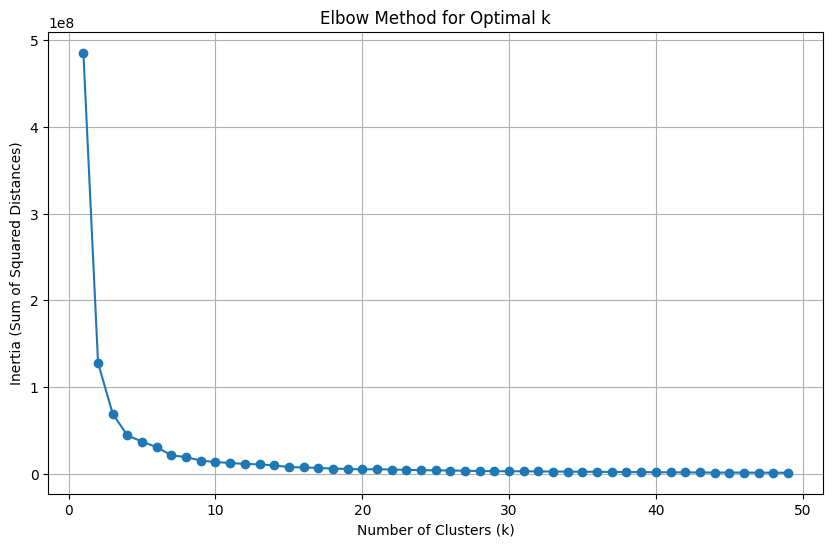

In [36]:
# Clustering based on geographical coordinates for challenge_set_updated

# Extract coordinates for adep and ades
adep_coords = challenge_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords = challenge_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Combine all coordinates for clustering
combined_coords = np.vstack((adep_coords, ades_coords))

# Calculate inertia for each k value in the specified range
inertia = []
k_range = range(1, 50)  # Testing cluster sizes from 1 to 50

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(combined_coords)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()
        
# Automatically determining the optimal k using the "elbow" point
# Finding the point where the reduction in inertia slows down significantly
optimal_k = 1  # Default to 1 cluster if no elbow is detected
threshold_ratio = 0.01  # Define a threshold for identifying the elbow point

# Checking for the point where inertia reduction starts to slow down
for i in range(1, len(inertia) - 1):
    if (inertia[i - 1] - inertia[i]) > (inertia[i] - inertia[i + 1]) * threshold_ratio:
        optimal_k = i + 1
        break

In [37]:
# Apply K-means clustering on combined coordinates
kmeans_geo = KMeans(n_clusters=20, random_state=42)  
kmeans_geo.fit(combined_coords)

# Assign cluster labels back to adep and ades separately
adep_geo_labels = kmeans_geo.predict(adep_coords)
ades_geo_labels = kmeans_geo.predict(ades_coords)

# Map cluster labels to the original dataframe
challenge_set_updated['adep_geo_cluster'] = adep_geo_labels
challenge_set_updated['ades_geo_cluster'] = ades_geo_labels

In [38]:
# Clustering based on geographical coordinates for submission_set_updated

# Extract coordinates for adep and ades from submission_set_updated
adep_coords_submission = submission_set_updated[['Latitude_adep', 'Longitude_adep']].values
ades_coords_submission = submission_set_updated[['Latitude_ades', 'Longitude_ades']].values

# Assign cluster labels back to adep and ades separately for submission_set_updated
adep_geo_labels_submission = kmeans_geo.predict(adep_coords_submission)
ades_geo_labels_submission = kmeans_geo.predict(ades_coords_submission)

# Map cluster labels to the submission_set_updated dataframe
submission_set_updated['adep_geo_cluster'] = adep_geo_labels_submission
submission_set_updated['ades_geo_cluster'] = ades_geo_labels_submission

In [39]:
# Automatically identify categorical variables in the DataFrame
categorical_columns_auto = challenge_set_updated.select_dtypes(include=['object', 'category']).columns.tolist()

# Calculate the number of unique values for each automatically identified categorical column
unique_variations_auto = challenge_set_updated[categorical_columns_auto].nunique()

# Display the identified categorical variables and their number of unique variations
unique_variations_auto

adep                        460
ades                        367
aircraft_type                30
wtc                           2
airline                      29
offblock_season               4
flight_duration_category      4
adep_region                   7
ades_region                   7
flight_direction              3
Manufacturer                  7
Model_FAA                    30
Physical_Class_Engine         2
FAA_Weight                    3
dtype: int64

In [40]:
# Calculate the number of unique values for each categorical column efficiently
unique_variations = challenge_set_updated[categorical_columns].nunique()

# Display the number of variations for each categorical variable
unique_variations

aircraft_type               30
wtc                          2
airline                     29
offblock_hour               24
offblock_minute             60
offblock_day_of_week         7
offblock_month              12
offblock_week_of_year       52
offblock_season              4
arrival_hour                24
arrival_minute              60
is_offblock_weekend          2
is_offblock_rush_hour        2
flight_duration_category     4
adep_region                  7
ades_region                  7
same_country_flight          2
same_region_flight           2
flight_direction             3
is_intercontinental          2
Manufacturer                 7
Model_FAA                   30
Physical_Class_Engine        2
FAA_Weight                   3
dtype: int64

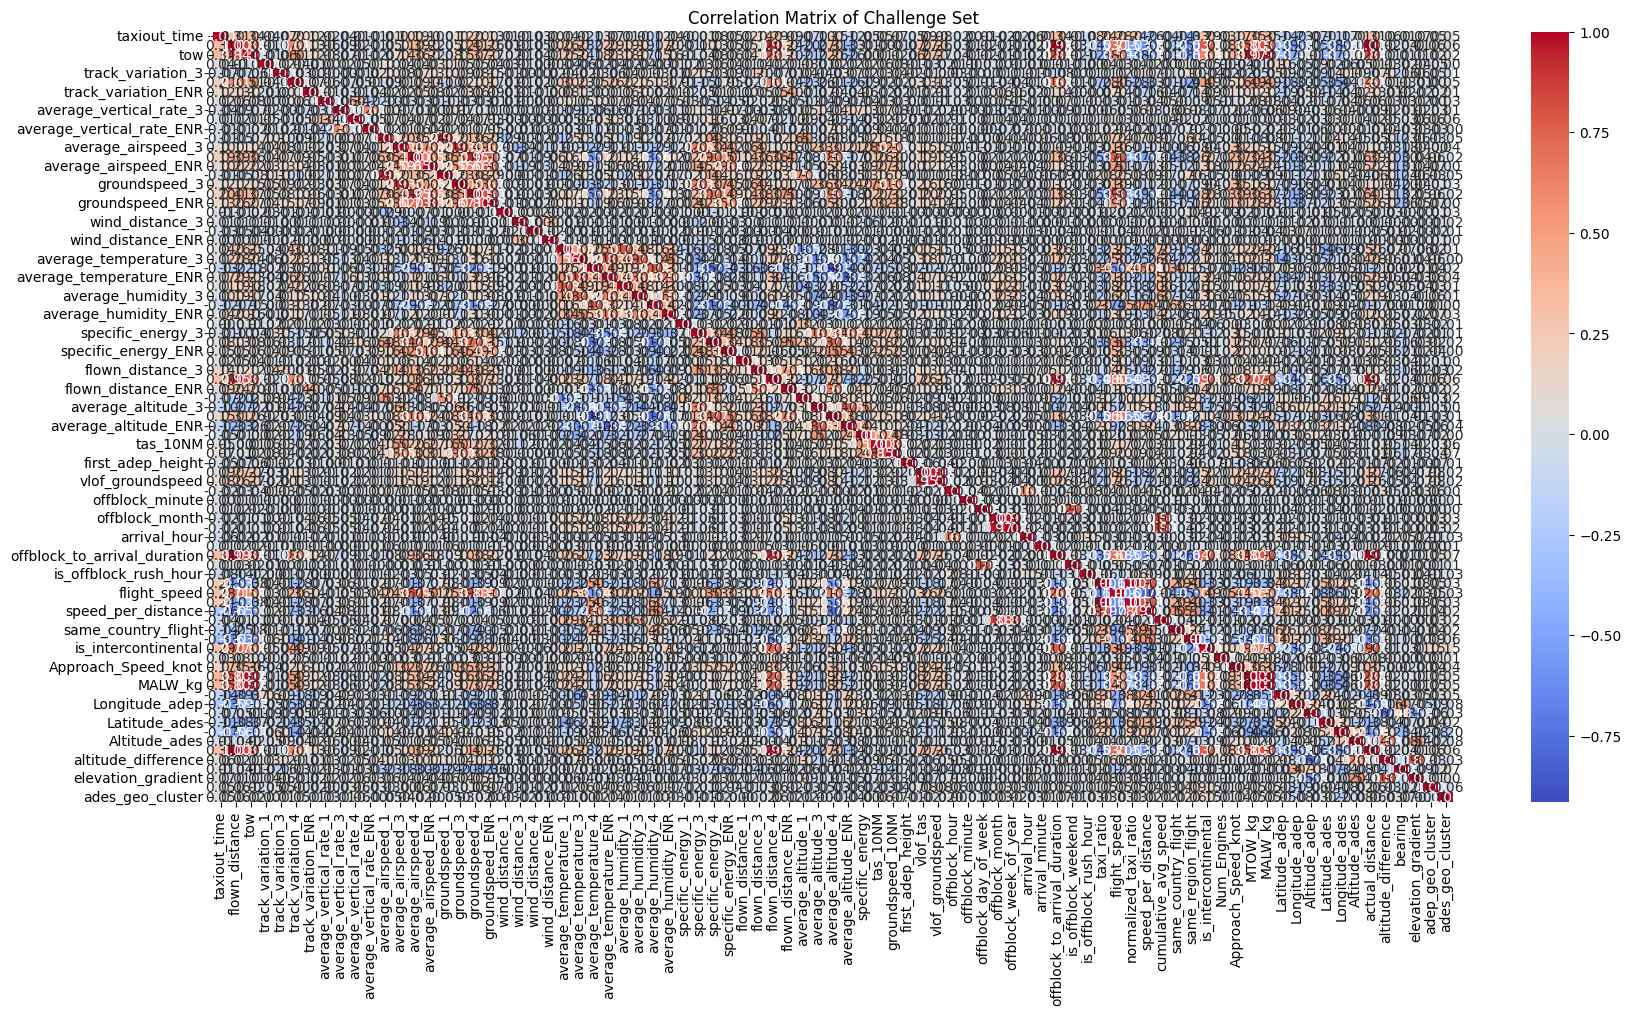

(        taxiout_time  flown_distance            tow  track_variation_1  \
 count  369013.000000   369013.000000  369013.000000      345273.000000   
 mean       13.507952     1021.728581   79482.257229          70.157664   
 std         5.755837     1128.171163   53250.919631          63.207379   
 min         1.000000       19.000000   14944.000000           0.000000   
 25%        10.000000      338.000000   55836.000000           2.249156   
 50%        12.000000      647.000000   63852.000000          63.004282   
 75%        16.000000     1113.000000   73756.000000         127.191421   
 max        90.000000     7272.000000  351327.000000         180.000000   
 
        track_variation_3  track_variation_4  track_variation_ENR  \
 count      341449.000000      352489.000000        317863.000000   
 mean           65.100437          31.310996            13.991210   
 std            58.956724          32.905881            16.423862   
 min             0.000000           0.000000   

In [41]:
# Summary statistics of the challenge set
challenge_summary = challenge_set_updated.describe()

# Check for missing values
missing_values = challenge_set_updated.isnull().sum()

# Correlation matrix to check relationships between numerical features
correlation_matrix = challenge_set_updated.corr(numeric_only=True)

# Plotting the correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Challenge Set')
plt.show()

# Display the summary statistics and missing values
challenge_summary, missing_values

In [42]:
# Function to rearrange the dataframe so that the target variable 'tow' is the last column
def rearrange_columns(df):
    # Moving 'tow' to the last position
    columns = [col for col in df.columns if col != 'tow'] + ['tow']
    df = df[columns]
    return df

# Remove some categorical columns
# mmaximo: I am not removing 'adep' and 'ades' anymore so I can use them to imput missing values
new_columns_to_remove = ['actual_distance']
# new_columns_to_remove = ['adep', 'ades', 'actual_distance']
challenge_set_updated = remove_columns(challenge_set_updated, new_columns_to_remove)
submission_set_updated = remove_columns(submission_set_updated, new_columns_to_remove)

# Apply One-Hot Encoding to the training set
# challenge_set_updated = pd.get_dummies(challenge_set_updated, columns=categorical_columns, drop_first=True)

# Apply One-Hot Encoding to the test set
# submission_set_updated = pd.get_dummies(submission_set_updated, columns=categorical_columns, drop_first=True)

# Align the test set columns with the training set columns
# Identify missing columns and create a DataFrame with those columns set to zero
missing_cols = set(challenge_set_updated.columns) - set(submission_set_updated.columns)
missing_cols_df = pd.DataFrame(0, index=submission_set_updated.index, columns=list(missing_cols))

# Concatenate the missing columns DataFrame with the test set
submission_set_updated = pd.concat([submission_set_updated, missing_cols_df], axis=1)

# Drop extra columns in the test set that are not in the training set
extra_cols = set(submission_set_updated.columns) - set(challenge_set_updated.columns)
submission_set_updated.drop(columns=list(extra_cols), inplace=True)

# Reorder the columns of the test set to match the training set
submission_set_updated = submission_set_updated[challenge_set_updated.columns]

# Rearrange columns
challenge_set_updated = rearrange_columns(challenge_set_updated)
submission_set_updated = rearrange_columns(submission_set_updated)


In [43]:
missing_cols

set()

In [44]:
extra_cols

set()

In [45]:
challenge_set_updated.T

0       \
adep                                            EGLL   
ades                                            EICK   
aircraft_type                                   A320   
wtc                                                M   
airline             a73f82288988b79be490c6322f4c32ed   
...                                              ...   
bearing                                   277.346455   
elevation_gradient                          0.232363   
adep_geo_cluster                                  17   
ades_geo_cluster                                   4   
tow                                          54748.0   

                                              1       \
adep                                            LEBL   
ades                                            KMIA   
aircraft_type                                   B772   
wtc                                                H   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                              ...   
bearing                                   285.530704   
elevation_gradient                         -0.000133   
adep_geo_cluster                                   7   
ades_geo_cluster                                   2   
tow                                         185441.0   

                                              2       \
adep                                            ESSA   
ades                                            KORD   
aircraft_type                                   A333   
wtc                                                H   
airline             8be5c854fd664bcb97fb543339f74770   
...                                              ...   
bearing                                   305.643136   
elevation_gradient                          0.024214   
adep_geo_cluster                                   9   
ades_geo_cluster                                   2   
tow                                         230396.0   

                                              3       \
adep                                            LSZH   
ades                                            KPHL   
aircraft_type                                   B788   
wtc                                                H   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                              ...   
bearing                                   296.005451   
elevation_gradient                         -0.065017   
adep_geo_cluster                                  11   
ades_geo_cluster                                  14   
tow                                         157615.0   

                                              4       \
adep                                            EIDW   
ades                                            EGLL   
aircraft_type                                   A21N   
wtc                                                M   
airline             a73f82288988b79be490c6322f4c32ed   
...                                              ...   
bearing                                   116.445141   
elevation_gradient                          -0.10915   
adep_geo_cluster                                   4   
ades_geo_cluster                                  17   
tow                                     70318.447226   

                                              5       \
adep                                            ENGM   
ades                                            LEAL   
aircraft_type                                   A20N   
wtc                                                M   
airline             8be5c854fd664bcb97fb543339f74770   
...                                              ...   
bearing                                   203.829766   
elevation_gradient                         -0.063803   
adep_geo_cluster                                   6   
ades_geo_cluster                                   7   
tow                                          57721.0   

        

In [46]:
submission_set_updated.T

0       \
adep                                            LTFJ   
ades                                            LFLL   
aircraft_type                                   B738   
wtc                                                M   
airline             6351ec1b849adacc0cbb3b1313d8d39b   
...                                              ...   
bearing                                   293.477205   
elevation_gradient                         -0.030154   
adep_geo_cluster                                   1   
ades_geo_cluster                                  11   
tow                                              NaN   

                                              1       \
adep                                            EBBR   
ades                                            KJFK   
aircraft_type                                   A333   
wtc                                                H   
airline             bdeeef3a675587d530de70a25d7118d2   
...                                              ...   
bearing                                   291.395141   
elevation_gradient                         -0.009004   
adep_geo_cluster                                   0   
ades_geo_cluster                                  14   
tow                                              NaN   

                                              2       \
adep                                            KMIA   
ades                                            EGLL   
aircraft_type                                   B77W   
wtc                                                H   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                              ...   
bearing                                    43.036806   
elevation_gradient                          0.003095   
adep_geo_cluster                                   2   
ades_geo_cluster                                  17   
tow                                              NaN   

                                              3       \
adep                                            EGCN   
ades                                            LEAL   
aircraft_type                                   B38M   
wtc                                                M   
airline             3922524069809ac4326134429751e26f   
...                                              ...   
bearing                                   178.644825   
elevation_gradient                         -0.006508   
adep_geo_cluster                                  17   
ades_geo_cluster                                   7   
tow                                              NaN   

                                              4       \
adep                                            EIDW   
ades                                            LFLL   
aircraft_type                                   A320   
wtc                                                M   
airline             a73f82288988b79be490c6322f4c32ed   
...                                              ...   
bearing                                   131.790949   
elevation_gradient                          0.149765   
adep_geo_cluster                                   4   
ades_geo_cluster                                  11   
tow                                              NaN   

                                              5       \
adep                                            LTFJ   
ades                                            LTAC   
aircraft_type                                   B738   
wtc                                                M   
airline             6351ec1b849adacc0cbb3b1313d8d39b   
...                                              ...   
bearing                                   104.173834   
elevation_gradient                          1.983765   
adep_geo_cluster                                   1   
ades_geo_cluster                                   1   
tow                                              NaN   

        

In [47]:
total_dataset = pd.concat([challenge_set_updated, submission_set_updated])
total_dataset.T

0       \
adep                                            EGLL   
ades                                            EICK   
aircraft_type                                   A320   
wtc                                                M   
airline             a73f82288988b79be490c6322f4c32ed   
...                                              ...   
bearing                                   277.346455   
elevation_gradient                          0.232363   
adep_geo_cluster                                  17   
ades_geo_cluster                                   4   
tow                                          54748.0   

                                              1       \
adep                                            LEBL   
ades                                            KMIA   
aircraft_type                                   B772   
wtc                                                H   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                              ...   
bearing                                   285.530704   
elevation_gradient                         -0.000133   
adep_geo_cluster                                   7   
ades_geo_cluster                                   2   
tow                                         185441.0   

                                              2       \
adep                                            ESSA   
ades                                            KORD   
aircraft_type                                   A333   
wtc                                                H   
airline             8be5c854fd664bcb97fb543339f74770   
...                                              ...   
bearing                                   305.643136   
elevation_gradient                          0.024214   
adep_geo_cluster                                   9   
ades_geo_cluster                                   2   
tow                                         230396.0   

                                              3       \
adep                                            LSZH   
ades                                            KPHL   
aircraft_type                                   B788   
wtc                                                H   
airline             5543e4dc327359ffaf5b9c0e6faaf0e1   
...                                              ...   
bearing                                   296.005451   
elevation_gradient                         -0.065017   
adep_geo_cluster                                  11   
ades_geo_cluster                                  14   
tow                                         157615.0   

                                              4       \
adep                                            EIDW   
ades                                            EGLL   
aircraft_type                                   A21N   
wtc                                                M   
airline             a73f82288988b79be490c6322f4c32ed   
...                                              ...   
bearing                                   116.445141   
elevation_gradient                          -0.10915   
adep_geo_cluster                                   4   
ades_geo_cluster                                  17   
tow                                     70318.447226   

                                              5       \
adep                                            ENGM   
ades                                            LEAL   
aircraft_type                                   A20N   
wtc                                                M   
airline             8be5c854fd664bcb97fb543339f74770   
...                                              ...   
bearing                                   203.829766   
elevation_gradient                         -0.063803   
adep_geo_cluster                                   6   
ades_geo_cluster                                   7   
tow                                          57721.0   

        

In [48]:
total_dataset.replace(np.inf, np.nan, inplace=True)

In [49]:
pd.set_option('display.max_rows', None)

print('Showing proportion of NaNs in the total dataset (challenge + submission):')
print(total_dataset.isna().sum()/total_dataset.shape[0])

pd.reset_option('display.max_rows')

Showing proportion of NaNs in the total dataset (challenge + submission):
adep                            0.000000
ades                            0.000000
aircraft_type                   0.000000
wtc                             0.000000
airline                         0.000000
taxiout_time                    0.000000
flown_distance                  0.000000
track_variation_1               0.064077
track_variation_3               0.074638
track_variation_4               0.044763
track_variation_ENR             0.138198
average_vertical_rate_1         0.064082
average_vertical_rate_3         0.074640
average_vertical_rate_4         0.044769
average_vertical_rate_ENR       0.138202
average_airspeed_1              0.064077
average_airspeed_3              0.074638
average_airspeed_4              0.044763
average_airspeed_ENR            0.138198
groundspeed_1                   0.064077
groundspeed_3                   0.074638
groundspeed_4                   0.044763
groundspeed_ENR         

In [50]:
num_nans = total_dataset.isna().sum().sum()
columns = total_dataset.columns[total_dataset.isna().sum() > 0]
columns = list(columns)
columns.remove('tow')

cropped_dataset = total_dataset[['adep', 'ades', 'aircraft_type'] + columns]
cropped_dataset.head()

median_values = cropped_dataset[columns].median()

print(median_values)

track_variation_1                63.116572
track_variation_3                57.722754
track_variation_4                23.119851
track_variation_ENR               9.006997
average_vertical_rate_1       -1219.249448
average_vertical_rate_3        2170.479804
average_vertical_rate_4         -20.083355
average_vertical_rate_ENR      1316.727662
average_airspeed_1              149.562076
average_airspeed_3              156.025658
average_airspeed_4              226.194293
average_airspeed_ENR            220.485013
groundspeed_1                   149.541497
groundspeed_3                   156.019487
groundspeed_4                   226.035596
groundspeed_ENR                 220.218436
wind_distance_1                   0.000000
wind_distance_3                   0.000000
wind_distance_4                   0.000000
wind_distance_ENR                 0.000000
average_temperature_1           264.669090
average_temperature_3           268.380826
average_temperature_4           221.111353
average_tem

In [51]:
grouped_dataset = cropped_dataset.groupby(['adep', 'ades', 'aircraft_type']).median()
grouped_dataset.head()

# print(grouped_dataset.shape[0])
# total_dataset_imputted = total_dataset
# total_dataset_imputted[columns] = grouped_dataset[columns]

track_variation_1  track_variation_3  \
adep ades aircraft_type                                         
BIKF EGCC B38M                  105.183027          86.789481   
          B738                  109.986771          75.921684   
     EGGD B38M                  154.563381          75.607158   
     EGKK B38M                    2.045728          19.299714   
          B738                    1.713003          72.027946   

                         track_variation_4  track_variation_ENR  \
adep ades aircraft_type                                           
BIKF EGCC B38M                   40.065320            10.595968   
          B738                   38.000411             4.635186   
     EGGD B38M                   55.137991             4.233354   
     EGKK B38M                   45.887458             8.427736   
          B738                   47.408502             2.591521   

                         average_vertical_rate_1  average_vertical_rate_3  \
adep ades aircraft_type                                                     
BIKF EGCC B38M                      -1198.344877              2309.635411   
          B738                      -1295.936502              2522.309731   
     EGGD B38M                      -1307.440918              2116.511475   
     EGKK B38M                       -937.706723              2395.100189   
          B738                       -946.005522              2439.509632   

                         average_vertical_rate_4  average_vertical_rate_ENR  \
adep ades aircraft_type                                                       
BIKF EGCC B38M                       -114.599751                1339.035300   
          B738                       -128.622430                1494.260870   
     EGGD B38M                        -28.026263                1341.082873   
     EGKK B38M                       -138.138013                1555.001821   
          B738                       -150.907232                1494.190275   

                         average_airspeed_1  average_airspeed_3  ...  \
adep ades aircraft_type                                          ...   
BIKF EGCC B38M                   148.261205          153.646837  ...   
          B738                   151.470413          155.129174  ...   
     EGGD B38M                   143.540139          145.121719  ...   
     EGKK B38M                   139.190075          145.426467  ...   
          B738                   140.983345          147.387680  ...   

                         average_altitude_1  average_altitude_3  \
adep ades aircraft_type                                           
BIKF EGCC B38M                 11823.224656        12397.763535   
          B738                 12377.579477        12382.008279   
     EGGD B38M                 13421.353815        11888.358459   
     EGKK B38M                 10051.197183        11188.405797   
          B738                 10354.344646        11324.238351   

                         average_altitude_4  average_altitude_ENR  \
adep ades aircraft_type                                             
BIKF EGCC B38M                 38195.516587          29581.481539   
          B738                 38375.446427          29936.646045   
     EGGD B38M                 37611.705161          29531.207367   
     EGKK B38M                 39770.106986          29290.478516   
          B738                 36540.215079          29419.280079   

                         specific_energy    tas_10NM  groundspeed_10NM  \
adep ades aircraft_type                                                  
BIKF EGCC B38M              49115.669643  156.247142             284.0   
          B738              44684.054636  138.344135             271.0   
     EGGD B38M              36541.203129  127.340494             257.5   
     EGKK B38M              41864.314345  141.892912             280.0   
          B738              39997.191419  140.023702             271.0   

                         fi

In [52]:
print('Number of NaNs:', total_dataset.isna().sum().sum())

Number of NaNs: 2261014


In [53]:
mask = (total_dataset['adep'] == 'BIKF') & (total_dataset['ades'] == 'EGCC') & (total_dataset['aircraft_type'] == 'B38M')
total_dataset.loc[mask]

adep  ades aircraft_type wtc                           airline  \
14968   BIKF  EGCC          B38M   M  3922524069809ac4326134429751e26f   
103439  BIKF  EGCC          B38M   M  3922524069809ac4326134429751e26f   

        taxiout_time  flown_distance  track_variation_1  track_variation_3  \
14968           10.0             931         107.349338         173.288123   
103439          10.0             933         103.016716           0.290839   

        track_variation_4  ...  Altitude_adep  Latitude_ades  Longitude_ades  \
14968           40.313321  ...             53         53.354          -2.275   
103439          39.817318  ...             53         53.354          -2.275   

        Altitude_ades  altitude_difference     bearing  elevation_gradient  \
14968              79                   26  126.071797            0.015728   
103439             79                   26  126.071797            0.015728   

        adep_geo_cluster  ades_geo_cluster      tow  
14968                  4                17  59835.0  
103439                 4                17      NaN  

[2 rows x 96 columns]

In [54]:
from tqdm import tqdm

num_elems = grouped_dataset.shape[0] * grouped_dataset.shape[1]
count = 0

# Uncomment to use the (adep, ades, aircraft_type) strategy!
# for group, row in tqdm(grouped_dataset.iterrows(), total=grouped_dataset.shape[0]):
#     adep = group[0]
#     ades = group[1]
#     aircraft_type = group[2]
#     mask = (total_dataset['adep'] == adep) & (total_dataset['ades'] == ades) & (total_dataset['aircraft_type'] == aircraft_type)
#     for col, value in row.items():
#         if not pd.isna(value):
#             total_dataset.loc[mask, col] = total_dataset.loc[mask, col].fillna(value)

In [55]:
mask = (total_dataset['adep'] == 'BIKF') & (total_dataset['ades'] == 'EGCC') & (total_dataset['aircraft_type'] == 'B38M')
total_dataset.loc[mask]

adep  ades aircraft_type wtc                           airline  \
14968   BIKF  EGCC          B38M   M  3922524069809ac4326134429751e26f   
103439  BIKF  EGCC          B38M   M  3922524069809ac4326134429751e26f   

        taxiout_time  flown_distance  track_variation_1  track_variation_3  \
14968           10.0             931         107.349338         173.288123   
103439          10.0             933         103.016716           0.290839   

        track_variation_4  ...  Altitude_adep  Latitude_ades  Longitude_ades  \
14968           40.313321  ...             53         53.354          -2.275   
103439          39.817318  ...             53         53.354          -2.275   

        Altitude_ades  altitude_difference     bearing  elevation_gradient  \
14968              79                   26  126.071797            0.015728   
103439             79                   26  126.071797            0.015728   

        adep_geo_cluster  ades_geo_cluster      tow  
14968                  4                17  59835.0  
103439                 4                17      NaN  

[2 rows x 96 columns]

In [56]:
print('Number of NaNs:', total_dataset.isna().sum().sum())

Number of NaNs: 2261014


In [57]:
pd.set_option('display.max_rows', None)

print('Showing proportion of NaNs in the total dataset (challenge + submission):')
print(total_dataset.isna().sum()/total_dataset.shape[0])

pd.reset_option('display.max_rows')

columns_with_nan = total_dataset.columns[total_dataset.isna().sum() > 0]
columns_with_nan = list(columns_with_nan)
columns_with_nan.remove('tow')
print(columns_with_nan)

Showing proportion of NaNs in the total dataset (challenge + submission):
adep                            0.000000
ades                            0.000000
aircraft_type                   0.000000
wtc                             0.000000
airline                         0.000000
taxiout_time                    0.000000
flown_distance                  0.000000
track_variation_1               0.064077
track_variation_3               0.074638
track_variation_4               0.044763
track_variation_ENR             0.138198
average_vertical_rate_1         0.064082
average_vertical_rate_3         0.074640
average_vertical_rate_4         0.044769
average_vertical_rate_ENR       0.138202
average_airspeed_1              0.064077
average_airspeed_3              0.074638
average_airspeed_4              0.044763
average_airspeed_ENR            0.138198
groundspeed_1                   0.064077
groundspeed_3                   0.074638
groundspeed_4                   0.044763
groundspeed_ENR         

In [58]:
for col in columns_with_nan:
    total_dataset[col] = total_dataset[col].fillna(median_values[col])

print('Number of NaNs (with tow):', total_dataset.isna().sum().sum())
print('Number of NaNs (in tow):', total_dataset['tow'].isna().sum())

challenge_set_updated = total_dataset[~total_dataset['tow'].isna()]
submission_set_updated = total_dataset[total_dataset['tow'].isna()]

print('Number of flights in challenge:', challenge_set_updated.shape[0])
print('Number of flights in submission:', submission_set_updated.shape[0])

Number of NaNs (with tow): 105959
Number of NaNs (in tow): 105959
Number of flights in challenge: 369013
Number of flights in submission: 105959


In [60]:
challenge_set_updated.to_csv('./data/challenge_set_updated_v13.csv', index=False)
submission_set_updated.to_csv('./data/submission_set_updated_v13.csv', index=False)